A script to train a nnU-Net V2 model, for reference.

In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
from utils.common import get_system_info, get_gpu_info
import os
import shutil
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

display(get_gpu_info())
display(get_system_info())

{'available': True,
 'count': 1,
 'names': ['NVIDIA GeForce RTX 3060 Laptop GPU'],
 'memory_gb': [5.99951171875],
 'cuda_version': '12.6'}

{'platform': 'Linux',
 'python_version': '3.10.12',
 'torch_version': '2.7.0+cu126',
 'cpu_count': 8,
 'cpu_count_logical': 16,
 'memory_gb': 7.6018829345703125}

#### Setup

In [10]:
# https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/installation_instructions.md
# Run only once!
# !git clone https://github.com/MIC-DKFZ/nnUNet.git
# !cd nnUNet; pip install -e .

Cloning into 'nnUNet'...
remote: Enumerating objects: 14008, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14008 (delta 0), reused 3 (delta 0), pack-reused 14005 (from 1)
Receiving objects: 100% (14008/14008), 8.61 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (10702/10702), done.
Updating files: 100% (246/246), done.
Obtaining file:///mnt/c/Users/abdal/Documents/Projects/ai-notebooks/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached graphviz-0.21-py3-none-any.whl (47 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (se

#### nnunetv2 for 3D data.

Dataset formatting.

In [40]:
# https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md
# https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_format.md
base_dir = os.getcwd()
data_path = os.path.join(base_dir, 'data')
nnUNet_raw = os.path.join(data_path, 'nnUNet_raw')

# create nnunet_raw dir
os.makedirs(nnUNet_raw, exist_ok=True)

# IBSR18 (3D) dataset for brain tissue segmentation wil be used as an example
# TODO: download the dataset into the data folder
ibsr18_path = os.path.join(data_path, 'IBSR18')

# nnUNet_raw: This is where you place the raw datasets. This folder will have one subfolder for each dataset names DatasetXXX_YYY 
# where XXX is a 3-digit identifier (such as 001, 002, 043, 999, ...) and YYY is the (unique) dataset name.

In [45]:
# create the new dataset folder with nnunet folder naming inside the nnUnet_raw folder
os.makedirs(os.path.join(nnUNet_raw, 'Dataset001_IBSR18'), exist_ok=True)

In [46]:
# Structuring the files inside the dataset folder
# Note that this dataset has a single input channel (one modality type, for example, one of FLAIR, T1w, T1gd or T2w), thus we use _0000

# Create new directory structure
os.makedirs(os.path.join(nnUNet_raw, 'Dataset001_IBSR18', 'imagesTr'), exist_ok=True)
os.makedirs(os.path.join(nnUNet_raw, 'Dataset001_IBSR18', 'imagesTs'), exist_ok=True)
os.makedirs(os.path.join(nnUNet_raw, 'Dataset001_IBSR18', 'labelsTr'), exist_ok=True)

# Function to handle the file copying and renaming
def handle_files(source_folder, dest_path, is_test=False):
    for folder_name in sorted(os.listdir(source_folder)):
        folder_path = os.path.join(source_folder, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.nii.gz'):
                    source_file = os.path.join(folder_path, file_name)
                    if '_seg' in file_name:
                        # For segmentation files (labels)
                        dest_file = os.path.join(dest_path, 'labelsTr', folder_name + '.nii.gz')
                    else:
                        # For image files
                        suffix = '_0000.nii.gz'
                        dest_file = os.path.join(dest_path, 'imagesTs' if is_test else 'imagesTr', folder_name + suffix)
                    shutil.copy2(source_file, dest_file)

# Process each set
# Here, 'Dataset001_IBSR18' is the newly named folder
handle_files(source_folder=os.path.join(ibsr18_path, 'Training_Set'), dest_path=os.path.join(nnUNet_raw, 'Dataset001_IBSR18'))
handle_files(source_folder=os.path.join(ibsr18_path, 'Validation_Set'), dest_path=os.path.join(nnUNet_raw, 'Dataset001_IBSR18'))
handle_files(source_folder=os.path.join(ibsr18_path, 'Test_Set'), dest_path=os.path.join(nnUNet_raw, 'Dataset001_IBSR18'), is_test=True)

From the nnUNet git repo: 'For each training case, all images must have the same geometry to ensure that their pixel arrays are aligned. Also make sure that all your data is co-registered!'

In [57]:
# Creating the required json file
def create_dataset_json(parent_dir):
    # Define the structure of the JSON file
    dataset_json = {
        "channel_names": {"0": "T1"},
        "labels": {
            "background": 0,
            "CFS": 1,
            "GM": 2,
            "WM": 3
         }, 
        "numTraining": 0,
        # "numTest": 0,
        # "training": [],
        # "test": [],
        "file_ending": ".nii.gz"
    }

    # Paths for training and test data
    training_images_path = os.path.join(parent_dir, "imagesTr")
    training_labels_path = os.path.join(parent_dir, "labelsTr")
    test_images_path = os.path.join(parent_dir, "imagesTs")

    # Scan for training images and labels
    if os.path.exists(training_images_path) and os.path.exists(training_labels_path):
        # training_images = sorted([f for f in os.listdir(training_images_path) if f.endswith('.nii.gz')])
        training_labels = sorted([f for f in os.listdir(training_labels_path) if f.endswith('.nii.gz')])
        # for img in training_labels:
        #     dataset_json["training"].append({
        #             "image": os.path.join("./imagesTr", img),
        #             "label": os.path.join("./labelsTr", img)
        #         })
        
        dataset_json["numTraining"] = len(training_labels)

    # Scan for test images
    # if os.path.exists(test_images_path):
    #     test_images = sorted([f for f in os.listdir(test_images_path) if f.endswith('.nii.gz')])
    #     for img in test_images:
    #         dataset_json["test"].append(os.path.join("./imagesTs", img))
        
    #     dataset_json["numTest"] = len(dataset_json["test"])

    # Write to JSON file
    try:
        with open(os.path.join(parent_dir, 'dataset.json'), 'w') as outfile:
            json.dump(dataset_json, outfile, indent=4)
            
        print(f"Dataset JSON created successfully")
    except IOError as e:
        print(f"Error creating JSON file: {e}")

create_dataset_json(os.path.join(nnUNet_raw, 'Dataset001_IBSR18'))

Dataset JSON created successfully


Experiment planning and preprocessing.

In [58]:
# nnUNet_raw = ... # already created before
nnUNet_preprocessed = os.path.join(data_path,'nnUNet_preprocessed')
results_folder = os.path.join(data_path,'nnUNet_results')

In [59]:
os.environ["nnUNet_raw"] = str(nnUNet_raw)
os.environ["nnUNet_preprocessed"] = str(nnUNet_preprocessed)
os.environ["nnUNet_results"] = str(results_folder)

In [60]:
# DATASET_ID=001 following the previous naming convention
!nnUNetv2_plan_and_preprocess -d 001 --verify_dataset_integrity

Fingerprint extraction...
Dataset001_IBSR18
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100%|███████████████████████████████████████████| 15/15 [00:30<00:00,  2.05s/it]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [115. 139. 147.], 3d_lowres: [115, 139, 147]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor

From the logs above, we notice the authors made an update to the planner. We can compare both approaches if GPU requirements were met.

https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md

Model training.

In [64]:
# Optional: hiddenlayer enables nnU-net to generate plots of the network topologies it generates
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git

  Cloning https://github.com/FabianIsensee/hiddenlayer.git to /tmp/pip-req-build-sg8mqs9e
  Running command git clone --filter=blob:none --quiet https://github.com/FabianIsensee/hiddenlayer.git /tmp/pip-req-build-sg8mqs9e
  Resolved https://github.com/FabianIsensee/hiddenlayer.git to commit b7263b6dc4569da1b6dea5964e1eac78fa32fa77
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for hiddenlayer, since package 'wheel' is not installed.
  Running setup.py install for hiddenlayer ... done


In [63]:
# hiddenlayer enables nnU-net to generate plots of the network topologies it generates
!nnUNetv2_train -h

usage: nnUNetv2_train [-h] [-tr TR] [-p P]
                      [-pretrained_weights PRETRAINED_WEIGHTS]
                      [-num_gpus NUM_GPUS] [--npz] [--c] [--val] [--val_best]
                      [--disable_checkpointing] [-device DEVICE]
                      dataset_name_or_id configuration fold

positional arguments:
  dataset_name_or_id    Dataset name or ID to train with
  configuration         Configuration that should be trained
  fold                  Fold of the 5-fold cross-validation. Should be an int
                        between 0 and 4.

options:
  -h, --help            show this help message and exit
  -tr TR                [OPTIONAL] Use this flag to specify a custom trainer.
                        Default: nnUNetTrainer
  -p P                  [OPTIONAL] Use this flag to specify a custom plans
                        identifier. Default: nnUNetPlans
  -pretrained_weights PRETRAINED_WEIGHTS
                        [OPTIONAL] path to nnU-Net checkpoint file 

In [112]:
# Creating a custom trainer to train for less amount of epochs, the nnUNetTrainer has 1000 epochs 
# nnUNet\nnunetv2\training\nnUNetTrainer\nnUNetTrainer.py

# IMPORTANT
# To avoid any training error with this trainer, we will need to move it in nnunetv2.training.nnUNetTrainer (../nnUNet/nnunetv2/training/nnUNetTrainer). 

# add the path to the cloned nnUNet folder to avoid any imports issues in the next trainer cell
# the code below is no longer needed to be in the notebook, just copy the trainer into a new trainer file in the nnunetv2.training.nnUNetTrainer as 
# mentioned above and configure the custom trainer there
# --------------------------------------------------------------------

# import sys, os
# sys.path.append(os.path.abspath("nnUNet"))

# from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
# class nnUNetTrainer_Fast(nnUNetTrainer):
#     def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, device: torch.device = torch.device('cuda')):
#         super().__init__(plans, configuration, fold, dataset_json, device)
#         # IMPORTANT: checkpoints are saved every 50 epochs, if epochs < 10, we won't be able to continue training the trained fold 
#         self.num_epochs = 51

In [122]:
# configuration 2d (a 2D U-Net for 2D and 3D datasets)
# nnU-Net stores a checkpoint every 50 epochs. If you need to continue a previous training, just add a --c to the training command.
# IMPORTANT: If you plan to use nnUNetv2_find_best_configuration (see below) add the --npz flag
# For FOLD in [0, 1, 2, 3, 4], run:
# !nnUNetv2_train DATASET_NAME_OR_ID 2d FOLD [--npz]

# IMPORTANT
# --c flag works per FOLD, thus each fold is trained independently and doesn't train folds in sequence

# if you trained a fold for 50 epochs, the trainer self.num_epochs value has to be updated (> than prev. value) to continue training further
# for example: if you trained FOLD 0 for 51 epochs (0-50 idx as the count starts from 0), changing self.num_epochs to 52 will start the epoch counter 
# in the logs from 51 (52 - 1 for 0th convention) and train for a single epoch.

# good to train a FOLD for many epochs as an experiment first and observe the loss curves, gives an idea on a good self.num_epochs value and could 
# prevent overfitting
# --------------------------------------------------------------------

# Training script; results file is created automatically
!nnUNetv2_train Dataset001_IBSR18 2d 0 -tr nnUNetTrainer_Fast --npz # FOLD 0


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-10-27 23:41:49.307967: Using torch.compile...
2025-10-27 23:41:52.035894: do_dummy_2d_data_aug: False
2025-10-27 23:41:52.044960: Using splits from existing split file: /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_preprocessed/Dataset001_IBSR18/splits_final.json
2025-10-27

In [123]:
!nnUNetv2_train Dataset001_IBSR18 2d 1 -tr nnUNetTrainer_Fast --npz # FOLD 1


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-10-28 00:11:41.808169: Using torch.compile...
2025-10-28 00:11:45.169210: do_dummy_2d_data_aug: False
2025-10-28 00:11:45.177801: Using splits from existing split file: /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_preprocessed/Dataset001_IBSR18/splits_final.json
2025-10-28

In [124]:
!nnUNetv2_train Dataset001_IBSR18 2d 2 -tr nnUNetTrainer_Fast --npz # FOLD 2


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-10-28 00:38:55.987139: Using torch.compile...
2025-10-28 00:38:58.620213: do_dummy_2d_data_aug: False
2025-10-28 00:38:58.633862: Using splits from existing split file: /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_preprocessed/Dataset001_IBSR18/splits_final.json
2025-10-28

In [125]:
!nnUNetv2_train Dataset001_IBSR18 2d 3 -tr nnUNetTrainer_Fast --npz # FOLD 3


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-10-28 01:06:40.460768: Using torch.compile...
2025-10-28 01:06:43.157297: do_dummy_2d_data_aug: False
2025-10-28 01:06:43.167215: Using splits from existing split file: /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_preprocessed/Dataset001_IBSR18/splits_final.json
2025-10-28

In [126]:
!nnUNetv2_train Dataset001_IBSR18 2d 4 -tr nnUNetTrainer_Fast --npz # FOLD 4


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-10-28 01:36:03.238420: Using torch.compile...
2025-10-28 01:36:06.155851: do_dummy_2d_data_aug: False
2025-10-28 01:36:06.169494: Using splits from existing split file: /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_preprocessed/Dataset001_IBSR18/splits_final.json
2025-10-28

Automatically determine the best configuration

In [127]:
# https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md#automatically-determine-the-best-configuration
!nnUNetv2_find_best_configuration -h

usage: nnUNetv2_find_best_configuration [-h] [-p P [P ...]] [-c C [C ...]]
                                        [-tr TR [TR ...]] [-np NP]
                                        [-f F [F ...]] [--disable_ensembling]
                                        [--no_overwrite]
                                        dataset_name_or_id

positional arguments:
  dataset_name_or_id    Dataset Name or id

options:
  -h, --help            show this help message and exit
  -p P [P ...]          List of plan identifiers. Default: nnUNetPlans
  -c C [C ...]          List of configurations. Default: ['2d', '3d_fullres',
                        '3d_lowres', '3d_cascade_fullres']
  -tr TR [TR ...]       List of trainers. Default: nnUNetTrainer
  -np NP                Number of processes to use for ensembling,
                        postprocessing etc
  -f F [F ...]          Folds to use. Default: 0 1 2 3 4
  --disable_ensembling  Set this flag to disable ensembling
  --no_overwrite        If set w

In [129]:
# nnUNetv2_find_best_configuration DATASET_NAME_OR_ID -c CONFIGURATIONS 
# we also added our custom trainer in the command
!nnUNetv2_find_best_configuration Dataset001_IBSR18 -c 2d -tr nnUNetTrainer_Fast


***All results:***
nnUNetTrainer_Fast__nnUNetPlans__2d: 0.9232307202265632

*Best*: nnUNetTrainer_Fast__nnUNetPlans__2d: 0.9232307202265632

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.89786 after: 0.83744
Results were improved by removing all but the largest component for 2. Dice before: 0.94053 after: 0.94057
Removing all but the largest component for 3 did not improve results! Dice before: 0.9313 after: 0.8908

***Run inference like this:***

nnUNetv2_predict -d Dataset001_IBSR18 -i INPUT_FOLDER -o OUTPUT_FOLDER -f  0 1 2 3 4 -tr nnUNetTrainer_Fast -c 2d -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_results/Dataset001_IBSR18/nnUNetTrainer_

Run inference

In [130]:
# https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md#run-inference
!nnUNetv2_predict -h


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

usage: nnUNetv2_predict [-h] -i I -o O -d D [-p P] [-tr TR] -c C
                        [-f F [F ...]] [-step_size STEP_SIZE] [--disable_tta]
                        [--verbose] [--save_probabilities]
                        [--continue_prediction] [-chk CHK] [-npp NPP]
                        [-nps NPS]
                        [-prev_stage_predictions PREV_STAGE_PREDICTIONS]
                        [-num_parts NUM_PARTS] [-part_id PART_ID]
                        [-device DEVICE] [--disable_progress_bar]

Use this to run inference with nnU-Net. This function is used when you want to
manua

In [163]:
# From the repo:
# Note that per default, inference will be done with all 5 folds from the cross-validation as an ensemble. 
# We very strongly recommend you use all 5 folds. Thus, all 5 folds must have been trained prior to running inference.
# If you wish to make predictions with a single model, train the all fold and specify it in nnUNetv2_predict with -f all

# nnUNetv2_predict -i INPUT_FOLDER -o OUTPUT_FOLDER -d DATASET_NAME_OR_ID -c CONFIGURATION --save_probabilities

# command from the best configuration, without saving probabilities
!nnUNetv2_predict -d Dataset001_IBSR18 -i data/nnUNet_raw/Dataset001_IBSR18/imagesTs -o data/nnUNet_raw/Dataset001_IBSR18/predictions -f  0 1 2 3 4 -tr nnUNetTrainer_Fast -c 2d -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 3 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 3 cases that I would like to predict

Predicting IBSR_02:
perform_everything_on_device: True
100%|█████████████████████████████████████████| 120/120 [00:03<00:00, 39.62it/s]
sending off prediction to background worker for resampling and export
done with IBSR_02

Predicting IBSR_10:
perform_everything_on_device: True
100%|█████████████████████████████████████████| 119/119 [00:03<00:00, 36.39it/s]
sending off prediction to background worker for resampling and export
don

In [164]:
# same command from the best configuration, with saving probabilities
# !nnUNetv2_predict -d Dataset001_IBSR18 -i data/nnUNet_raw/Dataset001_IBSR18/imagesTs -o data/nnUNet_raw/Dataset001_IBSR18/predictions_w_probs -f  0 1 2 3 4 -tr nnUNetTrainer_Fast -c 2d -p nnUNetPlans --save_probabilities


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 3 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 3 cases that I would like to predict

Predicting IBSR_02:
perform_everything_on_device: True
100%|█████████████████████████████████████████| 120/120 [00:02<00:00, 43.25it/s]
sending off prediction to background worker for resampling and export
done with IBSR_02

Predicting IBSR_10:
perform_everything_on_device: True
100%|█████████████████████████████████████████| 119/119 [00:02<00:00, 44.03it/s]
sending off prediction to background worker for resampling and export
don

In [ ]:
# additional repo notes:
# Ensembling multiple configurations
# If you wish to ensemble multiple predictions (typically form different configurations), you can do so with the following command:

# !nnUNetv2_ensemble -i FOLDER1 FOLDER2 ... -o OUTPUT_FOLDER -np NUM_PROCESSES

Apply postprocessing

In [166]:
# Finally, apply the previously determined postprocessing to the (ensembled) predictions
!nnUNetv2_apply_postprocessing -h

usage: Apples postprocessing specified in pp_pkl_file to input folder.
       [-h] -i I -o O -pp_pkl_file PP_PKL_FILE [-np NP]
       [-plans_json PLANS_JSON] [-dataset_json DATASET_JSON]

options:
  -h, --help            show this help message and exit
  -i I                  Input folder
  -o O                  Output folder
  -pp_pkl_file PP_PKL_FILE
                        postprocessing.pkl file
  -np NP                number of processes to use. Default: 8
  -plans_json PLANS_JSON
                        plans file to use. If not specified we will look for
                        the plans.json file in the input folder
                        (input_folder/plans.json)
  -dataset_json DATASET_JSON
                        dataset.json file to use. If not specified we will
                        look for the dataset.json file in the input folder
                        (input_folder/dataset.json)


In [167]:
# !nnUNetv2_apply_postprocessing -i FOLDER_WITH_PREDICTIONS -o OUTPUT_FOLDER --pp_pkl_file POSTPROCESSING_FILE -plans_json PLANS_FILE -dataset_json DATASET_JSON_FILE

!nnUNetv2_apply_postprocessing \
    -i data/nnUNet_raw/Dataset001_IBSR18/predictions \
    -o data/nnUNet_raw/Dataset001_IBSR18/predictions_postprocessed \
    -pp_pkl_file /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_results/Dataset001_IBSR18/nnUNetTrainer_Fast__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4/postprocessing.pkl \
    -np 8 \
    -plans_json /mnt/c/Users/abdal/Documents/Projects/ai-notebooks/data/nnUNet_results/Dataset001_IBSR18/nnUNetTrainer_Fast__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4/plans.json

Evaluation

Displaying IBSR_02_0000.nii.gz, slice 128/256
DICE (gt&pred): [0.3454803596781827, 0.6192302524703497, 0.5908761363819445], DICE (gt&pred_pp): [0.3454803596781827, 0.6192302524703497, 0.5908761363819445], DICE (pred&pred_pp): [1.0, 0.9999737243714976, 1.0]


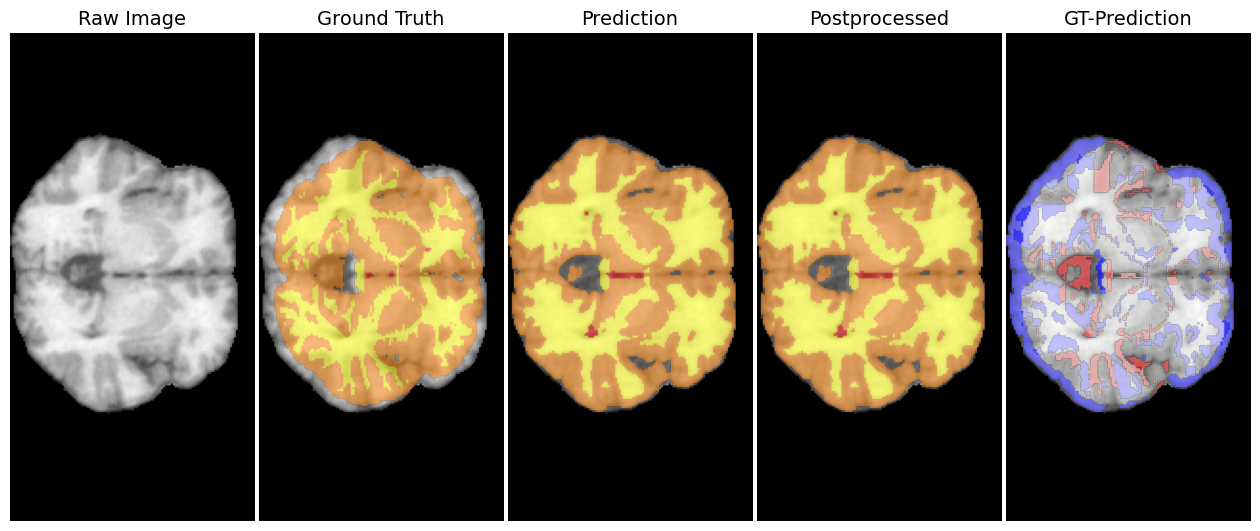

Displaying IBSR_10_0000.nii.gz, slice 128/256
DICE (gt&pred): [0.432328190743338, 0.4234400057863009, 0.48793275287297067], DICE (gt&pred_pp): [0.432328190743338, 0.4234400057863009, 0.48793275287297067], DICE (pred&pred_pp): [1.0, 0.9999809714526484, 1.0]


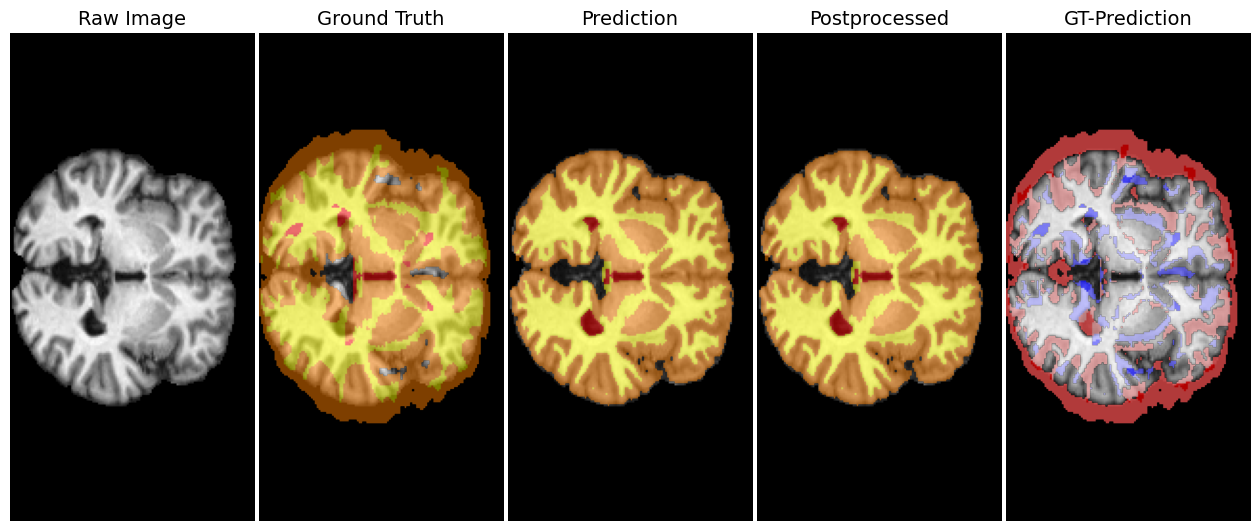

Displaying IBSR_15_0000.nii.gz, slice 128/256
DICE (gt&pred): [0.383004534819907, 0.7008151955815624, 0.6050653322463393], DICE (gt&pred_pp): [0.383004534819907, 0.7008151955815624, 0.6050653322463393], DICE (pred&pred_pp): [1.0, 1.0, 1.0]


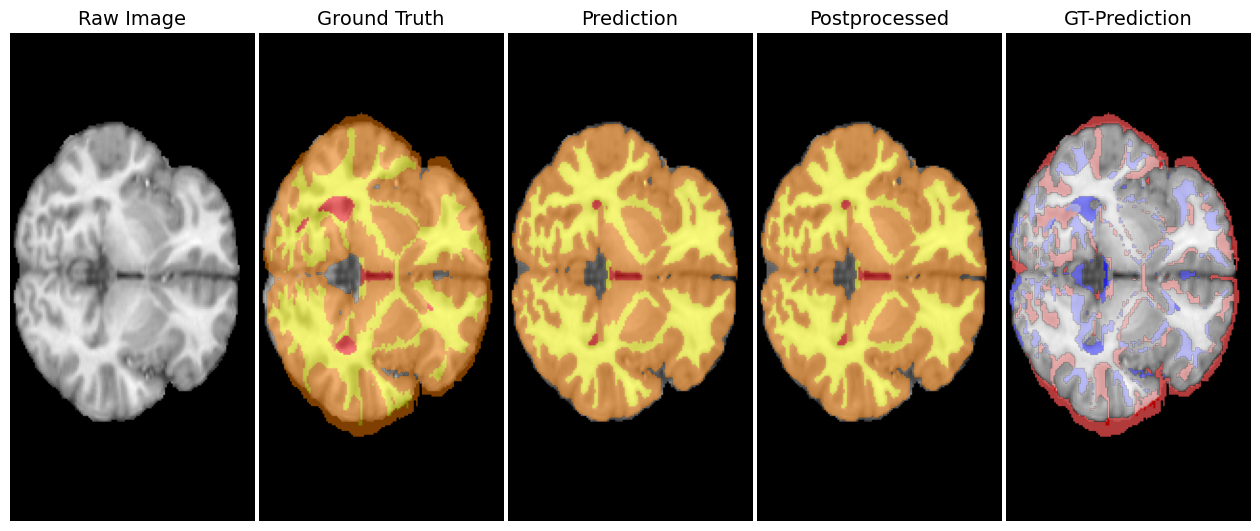

In [204]:
%matplotlib inline
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from utils.metrics import dice_score

def load_nifti(path):
    img = nib.load(path)
    return np.asanyarray(img.dataobj)
    
# --- Paths ---
dataset_path = os.path.join(nnUNet_raw, 'Dataset001_IBSR18')
test_dataset_path    = os.path.join(dataset_path, 'imagesTs')
test_dataset_gt_path = os.path.join(os.getcwd(), 'data', 'IBSR18', 'Test_Set_GT')
predictions_path     = os.path.join(dataset_path, 'predictions')
predictions_pp_path  = os.path.join(dataset_path, 'predictions_postprocessed')

for filename in os.listdir(test_dataset_path):
    img     = load_nifti(os.path.join(test_dataset_path, filename))
    gt      = load_nifti(os.path.join(test_dataset_gt_path, filename).replace('_0000',''))
    pred    = load_nifti(os.path.join(predictions_path, filename).replace('_0000',''))
    pred_pp = load_nifti(os.path.join(predictions_pp_path, filename).replace('_0000',''))

    # Match shapes if 4D (remove channel)
    img = np.squeeze(img, axis=-1) if img.ndim == 4 else img
    gt  = np.squeeze(gt,  axis=-1) if gt.ndim  == 4 else gt

    # Normalize image for display only
    img = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Middle slice
    slice_idx = img.shape[2] // 2
    print(f"Displaying {filename}, slice {slice_idx}/{img.shape[2]}")
    print(f"DICE (gt&pred): {dice_score(gt, pred)}, DICE (gt&pred_pp): {dice_score(gt, pred)}, DICE (pred&pred_pp): {dice_score(pred_pp, pred)}")
        
    # --- Compute difference map ---
    # Difference:  1 where prediction was removed, -1 where new region appeared, 0 otherwise
    diff = gt.astype(int) - pred.astype(int)

    # --- Plot setup ---
    fig, axes = plt.subplots(1, 5, figsize=(16, 20))
    titles = ["Raw Image", "Ground Truth", "Prediction", "Postprocessed", "GT-Prediction"]
    arrays = [img, gt, pred, pred_pp, diff]

    for ax, data, title in zip(axes, arrays, titles):
        ax.set_title(title, fontsize=14)
        if title == "Raw Image":
            ax.imshow(data[:, :, slice_idx], cmap="gray", aspect="equal")
        elif title == "GT-Prediction":
            ax.imshow(img[:, :, slice_idx], cmap="gray", aspect="equal")
            # highlight changes: removed (blue), added (red)
            ax.imshow(np.ma.masked_where(data[:, :, slice_idx] == 0, data[:, :, slice_idx]),
                      cmap="bwr", alpha=0.7, aspect="equal")
        else:
            ax.imshow(img[:, :, slice_idx], cmap="gray", aspect="equal")
            ax.imshow(np.ma.masked_where(data[:, :, slice_idx] == 0, data[:, :, slice_idx]),
                      cmap="autumn", alpha=0.5, aspect="equal")
        ax.axis("off")

    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

In the above samples, the gt files seem to be poorly annotated comparing it to the raw images.